# Carbon-Climate Box Model
## For ATMS/ESS/OCEAN 588
Written originally by Curtis Deutsch in matlab. Land component modified by Abby Swann. Ported to python by Diana Gergel and Abby Swann.

This Jupyter notebook contains all of the switches for options in the model as well as setup code, code that runs the model, and plotting code at the end.


### The lettered sections indicate areas you are most likely to interact with the code, the other sections are needed for running but don't need to be modified

### Import Packages

In [1]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os 
from collections import OrderedDict
from functools import partial
#import seawater as sw


from box_model_functions import co2_emissions, calc_pco2, get_matrix_index, carbon_climate_derivs

# added the necessary seawater functions to their own .py module
from seawater_functions import dens0, dens, seck, T68conv

# A. Pick a Model Configuration
In this section you pick the __type of model__ you want to run, e.g. land, ocean or coupled land-ocean, using a series of switches where on=1 and off=0. Before each run these configuration options should be checked and/or modified. 

The cell also conains the __scenario parameters__ for setting the fossil fuel emissions and variations in emissions.

There are a few parameters needed for the problem sets that you can set here which will change the values in the code farther down.

### __Most__ of the modifications you will make for all three problem sets take place in this section. 

In [2]:
PS = OrderedDict()

# Give your run a name
PS['runName'] = 'Land_Gobal_10yr'

###### Choose if land and ocean should be active (1=active, 0=not active)
PS['DoOcn'] = 0 # include ocean
PS['DoTer'] = 1 # include land

###### For the ocean, choose if each of the pumps should be active (1=active, 0=not active)
PS['DoOcnBio'] = 1 # include ocean biological pump (uptake/remin of Corg)
PS['DoOcnSol'] = 1 # include ocean solubility pump (SST variation)
PS['DoOcnCirc'] = 1 # include ocean solubility pump (SST variation)

###### Choose how carbon-climate coupling (CCC) processes will work (1=active, 0=not active)
PS['DoRadCO2'] = 0 # let climate respond to CO2 changes
PS['DoCplVUncpl'] = 0 # calculate both coupled and uncoupled solutions and compare output
if PS['DoCplVUncpl']==1:
    PS['DoRadCO2'] = 1 # let climate respond to CO2 changes, override user choice above
PS['CCC_LT'] = 1 # allow CCC via temperature effect on land C (e.g. respiration rate)
PS['CCC_LC'] = 1 # allow CCC via atm co2 effect on land C (e.g. co2 fertilization effect)
PS['CCC_OT'] = 1 # allow CCC via temperature on ocean C (e.g. solubility, circulation)
PS['CCC_OC'] = 1 # allow CCC via atm CO2 effect on ocean C (e.g. disequilibrium, buffer factor)


##### Choose an emissions scheme by specifing the co2 scenario 
# Options: 'rcp85', more options planned but not working yet ('zero', 'pulse','ramp1')
PS['escheme'] = 'rcp85' # emissions trajectory 
PS['cmax'] = 4 # co2 change factor used in ramp scenarios (e.g. 4 means 4x[patm0])


###### climate forcing 
# specify climate forcing 
PS['RFamp'] = 0 # amplitude of imposed RF oscillations [W/m2]
PS['RFper'] = 100 # period of oscillatory forcing [yr]

###### Terrestrial ecosystem and forcing
# Specity Ecosystem Type Here
# Options: 'Global', 'TropicalForest', 'TempForest','BorealForest','Grass'
PS['VegName'] = 'Global'

# specify NPP forcing 
PS['NPPamp'] = 0.5 # fractional amplitude of imposed NPP oscillations (0.5 means 50% change)
PS['NPPper'] = 10 # period of oscillatory forcing [yr]

# Land Parameters
PS['beta_550'] = 1 #1.25 # default is 1.25, can be modified to change the beta fertilization factor (try 1-1.5)
PS['Q10_resp'] = 2 # default is 2, can be modified to turn the Q10 for respiration up or down (try 1.5-2.5)

###### Ocean parameter modifications
PS['kwScalar'] = 1 # default is 1, can be modified to turn the piston velocity kw up or down (2, 0.5 etc)
PS['PsiScalar'] = 1 # default is 1, can be modified to turn circulation rates Psi up or down (2, 0.5 etc)

PS['dPsidb'] = 1/3 # default is 1/3, can be modified to turn the climate response of ocean circulation up or down (try 0-0.5)

The next section is used to setup some structures for the model to use, and specify constants (no need to modify)

In [3]:
# create Dictionary with model setup parameters 
PE = OrderedDict()

PE['re'] = 6371e3 # Earth radius
PE['Ae'] = 4 * np.pi * PE['re']**2; # Earth area
PE['sperd'] = 24 * 60 * 60; # seconds per day
PE['spery'] = PE['sperd'] * 365 # seconds per year
PE['fla'] = 0.3 # fraction land area
PE['foc'] = 1 - PE['fla'] # fraction ocean area
PE['ps'] = 1013.5 * 1e2  # mean surface pressure (Pa)
PE['ma'] = PE['ps'] * PE['Ae'] / 9.80 / 0.0290;   # mass of atmosphere (moles of air)
PE['patm0'] = 280e-6 # preindustrial co2 (atm)

# Structure and Indices of state variable arrays
PE['nd'] = 5 # number state variable 'domains' (Oc Temp, Oc Nutr, Oc CO2, Land C, Atm)
PE['np'] = 9 # number of carbon pools on land
PE['nb'] = 7 # number of boxes in ocean

# generic matrices
PE['m0'] = np.zeros((max(PE['np'],PE['nb']), PE['nd'])) 
PE['m1'] = np.ones((max(PE['np'],PE['nb']), PE['nd']))

arr_row_num = PE['m0'].shape[0]
arr_col_num = PE['m0'].shape[1]
PE['Itmp'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int'))
PE['Inut'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int') + 1)
PE['Icoc'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['nb']), np.zeros((1, PE['nb']), 
                                                                                         dtype='int') + 2)
PE['Icla'] = get_matrix_index(arr_row_num, arr_col_num, np.arange(0, PE['np']), np.zeros((1, PE['np']), 
                                                                                         dtype='int') + 3)
element_nums = np.arange(0, 9*5).reshape(arr_col_num, arr_row_num).transpose()
PE['Iatm'] = element_nums[0,4]
PE['Ires'] = np.hstack([PE['Itmp'], PE['Inut'], PE['Icoc'], PE['Icla'], PE['Iatm']])

# indices of pools in vector of m0(Ires)
PE['Jtmp'] = np.arange(0, PE['nb']);
PE['Jnut'] = np.arange(PE['nb'], (2 * PE['nb']))
PE['Jcoc'] = np.arange(2 * PE['nb'], 3 * PE['nb'])
PE['Jcla'] = np.arange(3 * PE['nb'], 3 * PE['nb'] + PE['np'])
PE['Jatm'] = PE['Jcla'][-1] + 1



# B. Choose the land parameters
In this section you setup land structures and define some parameters. 

### B.1 This is where you can modify the Q10 and beta fertilization factors for PS5.

In [4]:
PL = OrderedDict()

#---- specify the index for each land carbon pool
PL['iLeaf'] = 0  # leaf
PL['iRoot'] = 1  # root
PL['iWood'] = 2  # wood
PL['iLit1'] = 3  # metabolic litter
PL['iLit2'] = 4  # structural litter
PL['iCWDC'] = 5  # coarse woody debris
PL['iSOM1'] = 6  # soil organic matter 1
PL['iSOM2'] = 7  # soil organic matter 2
PL['iSOM3'] = 8  # soil organic matter 3

# Ae (earth area) coming from PE struct
PL['Ala'] = PE['Ae'] * PE['fla'] # Land area

# default parameters 
PL['Q10_resp'] = 2
PL['beta_550'] = 1.25
# if specified in setup section, overrride defaults and keep user chosen values
if 'Q10_resp' in PS:
    PL['Q10_resp'] = PS['Q10_resp']
if 'beta_550' in PS:
    PL['beta_550'] = PS['beta_550']
    
PL['beta_fert'] = (PL['beta_550'] - 1) / np.log(550 / 365)
PL['bcoef'] = np.zeros((PE['np'], 1))
PL['bcoef'][PL['iLeaf']] = 0.30     # leaf
PL['bcoef'][PL['iRoot']] = 0.50     # root

# create tauL array
tauL = np.empty([9], dtype='float')


### B.2 Set the timescales (tau) here (PS2)
If you want to switch between Ecosystem types (i.e. Global vs. Tropical Forest) you do that in Section A above.

In [5]:
# global mean case
if PS['VegName'] == "Global":
    NPP_o = 50    # Net Primary Production [Pg C/yr]
    NPP_o = NPP_o * 1e15 / 12 / PE['spery'] / PL['Ala'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iWood']] = 0.20      # wood
    # base turnover rate for pool j (tau is in years)
    tauL[PL['iLeaf']] = 1
    tauL[PL['iRoot']] = 10
    tauL[PL['iWood']] = 40
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 50
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 303
elif PS['VegName'] == "TropicalForest":
    NPP_o = 200    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE['spery'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 100
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 10
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 50
elif PS['VegName'] == "TempForest":
    NPP_o = 80    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE['spery'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 30
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 25
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 300
elif PS['VegName'] == "BorealForest":
    NPP_o = 35    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE['spery'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iRoot']] = 0.30      # root
    PL['bcoef'][PL['iWood']] = 0.40      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 35
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 5
    tauL[PL['iCWDC']] = 50
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 10
    tauL[PL['iSOM3']] = 500
elif PS['VegName'] == "Grass":
    NPP_o = 200    # Net Primary Production [g C/m2/yr]
    NPP_o = NPP_o / 12 / PE['spery'] # convert to molC/m2/s
    Rh_o = NPP_o # steady state (preindustrial)
    PL['bcoef'][PL['iLeaf']] = 0.50      # leaf
    PL['bcoef'][PL['iRoot']] = 0.50      # root
    PL['bcoef'][PL['iWood']] = 0.0      # wood
    tauL[PL['iLeaf']] = 2
    tauL[PL['iRoot']] = 2
    tauL[PL['iWood']] = 1
    tauL[PL['iLit1']] = 0.5
    tauL[PL['iLit2']] = 0.5
    tauL[PL['iCWDC']] = 1
    tauL[PL['iSOM1']] = 0.5
    tauL[PL['iSOM2']] = 2.5
    tauL[PL['iSOM3']] = 10
else: 
    raise AssertionError("this case is incorrectly defined")

PL['NPP_o'] = NPP_o


The next section contains more __land parameters__ like how much of the output from each pool goes to other pools and the fractional respiration losses (no need to modify)

In [6]:
# Land Model setup
# these variables are the same for all biomes 
kbase = np.zeros((PE['np'], 1))
kbase[PL['iLeaf']] = 1 / tauL[PL['iLeaf']]
kbase[PL['iRoot']] = 1 / tauL[PL['iRoot']]
kbase[PL['iWood']] = 1 / tauL[PL['iWood']]

kbase[PL['iLit1']] = 1 / tauL[PL['iLit1']]
kbase[PL['iLit2']] = 1 / tauL[PL['iLit2']]
kbase[PL['iCWDC']] = 1 / tauL[PL['iCWDC']]

kbase[PL['iSOM1']] = 1 / tauL[PL['iSOM1']]
kbase[PL['iSOM2']] = 1 / tauL[PL['iSOM2']]
kbase[PL['iSOM3']] = 1 / tauL[PL['iSOM3']]

kbase = kbase / PE['spery'] # convert to 1/sec
PL['kbase'] = kbase

krate = np.zeros((kbase.shape[0], kbase.shape[0]))
krate_row, krate_col = np.diag_indices(krate.shape[0])
krate[krate_row,krate_col] = kbase.flatten()

# krate = np.diag(kbase)
PL['krate'] = krate # scaled turnover rate

#### fractional carbon flow from pool j to pool i (pathf(i,j))
pathf = np.zeros((PE['np'], PE['np']))

pathf[PL['iLit1'], PL['iLeaf']] = 0.6
pathf[PL['iLit2'],PL['iLeaf']] = 0.4

pathf[PL['iLit1'],PL['iRoot']] = 0.6
pathf[PL['iLit2'],PL['iRoot']] = 0.4

pathf[PL['iCWDC'],PL['iWood']] = 1.0

pathf[PL['iSOM1'],PL['iLit1']] = 1.0

pathf[PL['iSOM2'],PL['iLit2']] = 0.15
pathf[PL['iSOM1'],PL['iLit2']] = 1. - pathf[PL['iSOM2'], PL['iLit2']]

pathf[PL['iSOM2'],PL['iCWDC']] = 0.25
pathf[PL['iSOM1'],PL['iCWDC']] = 1. - pathf[PL['iSOM2'],PL['iCWDC']]

pathf[PL['iSOM3'],PL['iSOM1']] = 0.01;
pathf[PL['iSOM2'],PL['iSOM1']] = 1. - pathf[PL['iSOM3'],PL['iSOM1']]

pathf[PL['iSOM3'],PL['iSOM2']] = 0.005
pathf[PL['iSOM1'],PL['iSOM2']] = 1. - pathf[PL['iSOM3'],PL['iSOM2']]

pathf[PL['iSOM1'],PL['iSOM3']] = 1.0
PL['pathf'] = pathf
                                            
######### fractional respiration loss for carbon flow from pool j to pool i
respf = np.zeros((PE['np'], PE['np']))

respf[PL['iLit1'],PL['iLeaf']] = 0.
respf[PL['iLit2'],PL['iLeaf']] = 0.

respf[PL['iLit1'],PL['iRoot']] = 0.
respf[PL['iLit2'],PL['iRoot']] = 0.

respf[PL['iCWDC'],PL['iWood']] = 0.

respf[PL['iSOM1'],PL['iLit1']] = 0.55

respf[PL['iSOM2'],PL['iLit2']] = 0.30
respf[PL['iSOM1'],PL['iLit2']] = 0.55

respf[PL['iSOM2'],PL['iCWDC']] = 0.30
respf[PL['iSOM1'],PL['iCWDC']] = 0.45

respf[PL['iSOM3'],PL['iSOM1']] = 0.
respf[PL['iSOM2'],PL['iSOM1']] = 0.45

respf[PL['iSOM3'],PL['iSOM2']] = 0.
respf[PL['iSOM1'],PL['iSOM2']] = 0.55

respf[PL['iSOM1'],PL['iSOM3']] = 0.55
PL['respf'] = respf

# fractional carbon flow from pool j that enters pool i
a = np.zeros((PE['np'], PE['np']), int)
np.fill_diagonal(a, -1.0)
PL['acoef'] = a + (pathf * (1. - respf))

Setup some necessary parameters and model structures for the overall simulation (no need to modify)

In [7]:
###### time parameters

PS['yspin'] = 5000 # length of spinup period in years (needed for ocean)
PS['yend'] = 2100 # time at end (calendar year)

if PS['escheme'] == "rcp85":
#if PS['escheme'][0:3] == "rcp":
    ypert = 1750 # time of perturbation (calendar year)
elif PS['escheme'] == "ramp1":
    ypert = PS['yend'] - PS['cmax']/2*70
elif PS['escheme'] == "pulse":
    ypert = 1800;
else:
    print('assuming idealized case')
    ypert = PS['yspin'];
    yend = ypert + PS['NPPper'] * 20;
PS['ypert'] = ypert
PS['ytot'] = PS['yspin'] + (PS['yend'] - ypert) # total run length

# radiative and NPP forcing 

# forcing is external (non-CO2, non-Temp mechanisms)
# may be stochastic or periodic (requires manual switch)

PS['Yint'] = np.arange(ypert, PS['yend'] + 0.1, step=0.1) # year of perturbation time series

PS['RFint'] = PS['RFamp'] * (np.sin(((PS['Yint'] - ypert)* 2 * np.pi / (PS['RFper']))));

PS['NPPint'] = PS['NPPamp'] * (np.sin(((PS['Yint'] - ypert) * 2 * np.pi / (PS['NPPper']))));



## C. Choose Ocean Parameters

### C.0 Ocean Setup
Setup for __ocean parameters__ are in the cell below (no need to modify).

In [8]:
PO = OrderedDict()

# box indices 
PO['Isfc'] = np.arange(0, 4)
PO['Idp'] = np.arange(4, 7)
    
PO['iAA'] = 0 # Antarctic surface
PO['iSA'] = 1 # Subantarctic surface
PO['iNA'] = 3 # N. Atlantic surface
PO['iLL'] = 2 # Low latitude surface
PO['iTC'] = 4 # Thermocline
PO['iNADW'] = 5 # North Atlantic Deep Water
PO['iAABW'] = 6 # Antarctic Bottom Water

# geometry 
PO['Aoc'] = PE['Ae'] * PE['foc'] # Ocean area
PO['Voc'] = 1.292e18 # Ocean volume

# surface boxes
H = np.empty([7], dtype='float')
A = np.empty([7], dtype='float')
V = np.empty([7], dtype='float')
H[PO['Isfc']]  = [250, 250, 100, 250]  # Surface box depths
A[PO['Isfc']]  = np.array([0.05, 0.1, 0.75, 0.1]) * PO['Aoc'] # Surface box areas
# V[Isfc]  = A * H # Box volume (surface)
V  = A * H # Box volume (surface)

# thermocline + deep boxes
### need to update these indices
H[4] = 900 
A[4] = A[2] 
V[4] = A[4] * H[4]
A[5:7] = PO['Aoc']
V[5:7] = np.array([0.35, 0.65]) * (PO['Voc'] - sum(V))
H[5] = np.linalg.lstsq(A[5:7].reshape(2, 1), V[5:7], rcond=None)[0][0]
H[6] = np.linalg.lstsq(A[5:7].reshape(2, 1), V[5:7], rcond=None)[0][0]

PO['H'] = H
PO['A'] = A
PO['V'] = V

### C.1 Ocean Circulation
You can find Psi, the circulation rates, in the box below - but the easy way to modify Psi is in Section A

In [9]:
### circulation (if DoOcnCirc=1)

##if PS['DoOcnCirc'] == 1: ## not an actual loop in matlab, will be overridden later if Psi is set to zero
PsiN_o = PS['PsiScalar'] * 20 * (1e6) # NADW overturning [Sv]
PsiS_o = PS['PsiScalar'] * 20 * (1e6) # AABW overturning [Sv]
PsiT_o = PS['PsiScalar'] * 100 * (1e6) # Thermocline overturning [Sv]
PsiM_o = PS['PsiScalar'] * 40 * (1e6) # convective mixing [Sv]

PsiNmat = np.zeros((PE['nb'],PE['nb']))
PsiNroute = [PO['iNA'], PO['iNADW'], PO['iAABW'], PO['iAA'], PO['iSA'], PO['iTC'], PO['iNA']]  # path of NADW 
for i in np.arange(0, len(PsiNroute) - 1):
    PsiNmat[PsiNroute[i], PsiNroute[i+1]] = 1

PsiSmat = np.zeros((PE['nb'], PE['nb']))
PsiSroute = [PO['iAA'], PO['iAABW'], PO['iAA']] # path of AABW
for i in np.arange(0, len(PsiSroute) - 1):
    PsiSmat[PsiSroute[i], PsiSroute[i+1]] = 1

PsiTmat = np.zeros((PE['nb'],PE['nb']))
PsiTroute = [PO['iLL'], PO['iTC'], PO['iLL']] # path of Thermocline MOC
for i in np.arange(0, len(PsiTroute) - 1):
    PsiTmat[PsiTroute[i], PsiTroute[i+1]] = 1
    
PsiMmat = np.zeros((PE['nb'],PE['nb']))
PsiMroute = [PO['iNA'], PO['iNADW'], PO['iNA']] # path of PsiM
for i in np.arange(0, len(PsiMroute) - 1):
    PsiMmat[PsiMroute[i], PsiMroute[i+1]] = 1

# Total transport matrix
Psi = (PsiTmat.transpose() * PsiT_o + PsiSmat.transpose() * PsiS_o + PsiNmat.transpose() * \
       PsiN_o + PsiMmat.transpose() * PsiM_o)

for i in np.arange(0, PE['nb']):
    Psi[i, i] = -1 * np.sum(Psi[i, :])

Psi = Psi / np.tile(V.reshape(PE['nb'], 1), (1, PE['nb'])) # divide by volume to get timescale
Psi_o = Psi

PO['Psi_o'] = Psi_o
PO['Psi'] = Psi

### C.2 Other Ocean Parameters
You can find the piston velocity kw below under "gas exchange parameters" but the easy way to modify kw is in Section A

In [10]:
# Biological damping time scales (surface boxes)

tau_bio = [5, 10, 1, 10] # timescale for surface nutrient damping [units: years]
lam_bio = 1. / (np.array(tau_bio) * PE['spery']) * PS['DoOcnBio']

# matrix for biological uptake (surface boxes)
PO['Qup'] = np.zeros((PE['nb'], PE['nb']))

for i in PO['Isfc']:
    PO['Qup'][PO['Isfc'][i], PO['Isfc'][i]] = -1 * lam_bio[PO['Isfc'][i]]
    
# matrix for remineralization (subsurface boxes)
remfac = np.zeros((PE['nb'],PE['nb']))
## need to adjust matrix indices probably  - look like they have been adjusted from matlab to python
remfac[1,5] = 0.8
remfac[2,4] = 0.8
remfac[2,5] = 0.1
remfac[3,5] = 0.8
remfac[PO['Isfc'], PE['nb']-1] = 1 - np.sum(remfac[PO['Isfc'], 0:PE['nb']], 1) # ensure complete remineralization (i.e. no burial)

vscale = np.tile(V.reshape(1, PE['nb']), (PE['nb'], 1)) / np.tile(V.reshape(PE['nb'], 1), (1, PE['nb']))
Qrem = np.multiply(remfac.transpose(), vscale)

for i in PO['Isfc']:
    Qrem[:,PO['Isfc'][i]] = Qrem[:,PO['Isfc'][i]] * lam_bio[PO['Isfc'][i]]
PO['Qrem'] = Qrem
    
# surface properties
# initialize matricies
T = np.empty([4], dtype='float')
S = np.empty([4], dtype='float')
TA = np.empty([7], dtype='float')
Fice = np.empty([7], dtype='float')
kw = np.empty([7], dtype='float')

T[PO['Isfc']] = [0, 8, 22, 3] # surface box temperature (degC)
S[PO['Isfc']] = [34, 34, 36, 35.5] # surface box salinity (psu)
TA[PO['Isfc']] = np.array([2390, 2350, 2320, 2325]) *1e-3 # Alkalinity [mol/m3]

# gas exchange parameters
kw[PO['Isfc']]= PS['kwScalar'] * 3 / PE['sperd'] # piston velocity [m/s]
Fice[PO['Isfc']] = [0.1, 0.1, 0, 0.1] # fractional ice coverage
kwi = np.multiply(kw, (1-Fice)) # effective piston velocity [m/s]
kwi[PO['Idp']] = 0
PO['kwi'] = kwi

# carbon and nutrient parameters
Pbar = 2.70e15 / PO['Voc'] # Global mean PO4 [mol/m3]
PO['pH0'] = np.ones((1, PE['nb'])) * 8 # initial guess for pH
PO['Rcp'] = 106 # Plankton DIC:PO4 ratio
TA[PO['Idp']] = TA[0] # This is arbitrary (deep Alk not used)

## Compute some steady states

# preformed matrix
sfac = np.zeros((PE['nb'],PE['nb']))
for i in PO['Isfc']:
    sfac[PO['Isfc'][i], PO['Isfc'][i]] = 1
#Apre = [Psi, sfac] ## this has 3 dimensions, should only have 2?
Apre = np.concatenate((Psi, sfac),axis=0)

# PO4
Amat = Psi + PO['Qup'] + PO['Qrem']
Amat[-1, :] = V / np.sum(V)
b = np.zeros((1,PE['nb']))
b[0, -1] = Pbar
# https://stackoverflow.com/questions/7160162/left-matrix-division-and-numpy-solve
Peq, resid, rank, s = np.linalg.lstsq(Amat, b.transpose(), rcond=None)
Peq = Peq * 1e3
PO['Peq'] = Peq

# Ppre, Preg
bpre = np.zeros((PE['nb']*2,1))
bpre[PE['nb'] + PO['Isfc']] = PO['Peq'][PO['Isfc']]
# Ppre = Apre\bpre;
Ppre, resid, rank, s = np.linalg.lstsq(Apre, bpre, rcond=None)
Preg = PO['Peq'] - Ppre

# T, S
bpre = np.zeros((PE['nb']*2,1)) 
bpre[PE['nb'] + PO['Isfc']] = np.reshape(T[PO['Isfc']],(len(T[PO['Isfc']]),1)) 
# T=(Apre\bpre)';
T, resid, rank, s = np.linalg.lstsq(Apre, bpre, rcond=None)#.transpose())
T = T.transpose()
bpre = np.zeros((PE['nb']*2,1)) 
bpre[PE['nb'] + PO['Isfc']] = np.reshape(S[PO['Isfc']],(len(S[PO['Isfc']]),1))
# S=(Apre\bpre)';
S, resid, rank, s = np.linalg.lstsq(Apre, bpre, rcond=None)
S = S.transpose()

Age = np.zeros((PE['nb'],1))
Age[PO['Isfc']] = 0
# need to update indices - I think this is done
Age[4] = V[4] / (PsiT_o + PsiN_o) / PE['spery']
Age[5] = V[5] / (PsiM_o + PsiN_o) / PE['spery']
Age[6] = V[6] / (PsiS_o + PsiN_o) / PE['spery']

# add to dictionary
PO['T'] = T
PO['S'] = S
PO['TA'] = TA


## climate params

PO['cp'] = 4185 # specific heat of water [J/kg/K]
#####################
if PS['DoOcn'] == 1:
  #  PO['rho_o'] = sw.dens(PO['S'], PO['T'], PO['T'] * 0).flatten() # density [kg/m3]  ###!!! NEEDS FIXING HERE!!!###
    PO['rho_o'] = dens(PO['S'], PO['T'], PO['T'] * 0).flatten() # density [kg/m3]  ###!!! NEEDS FIXING HERE!!!###
else: # hack for when the ocn isn't running (probably need to remove later?)
    PO['rho_o'] = np.transpose([0.0010273, 0.0010265, 0.0010250, 0.0010283, 0.0010250, 0.0010284, 0.0010273])
###########################################
PO['cm'] = PO['cp'] * PO['rho_o'] * (PO['V'] / PO['A']) # specific heat capacity of ocean boxes

###################################################################### convert lambda to a diff name bc python #####
lammbda = 1 / (10 * PE['spery']) * PO['V'] 
lammbda[PO['Idp']] = 0 # radiative damping 
PO['lammbda'] = lammbda
PO['dPsidb'] = 1 / 3 # scaling between overturning and buoyancy gradient
if 'dPsidb' in PS:
    PO['dPsidb'] = PS['dPsidb']


# turn off circulation if DoOcnCirc=0
if PS['DoOcnCirc'] == 0:
    PO['Psi'] = np.zeros((PE['nb'], PE['nb']))
    PO['Psi_o'] = np.zeros((PE['nb'], PE['nb']))

## Set up an initial state for the whole model
No need to modify

In [11]:
# prescribe or compute initial size of each reservoir/pool
if PS['DoOcn'] == 1:
    Nut_o = PO['Peq'] * 1e-3 # initial ocean nutrient concentration in each box (mol/m3)
    Coc_o = np.array([2388, 2351, 2322, 2325, 2120, 2177, 2329]) * 1e-3 # initial ocean DIC (mol/m3)
    Tmp_o = 0*Nut_o # initial temperature anomaly (deg C)

lt_side = -1* np.matmul(PL['acoef'], PL['krate'])
rt_side = (PL['bcoef'] * PL['NPP_o']).reshape(9, 1)
Cla_o = np.linalg.solve(lt_side, rt_side) # initial land carbon (steady state)
Cat_o = PE['patm0'] # initial atmos. pCO2 (uatm, or ppm)

# package initial values into array
# this makes it easier to identify domains (rows) and pools (columns)
y0mat = PE['m0'] # start with dummy matrix

y0mat_shape = y0mat.shape
y0mat_flat = y0mat.flatten()

y0mat_flat[PE['Icla']] = Cla_o.flatten()
y0mat_flat[PE['Iatm']] = Cat_o

if PS['DoOcn'] == 1:
    y0mat_flat[PE['Itmp']] = Tmp_o.flatten() # put temperature values into matrix
    y0mat_flat[PE['Inut']] = Nut_o.flatten() # ditto ocean nutrient, etc.
    y0mat_flat[PE['Icoc']] = Coc_o.flatten()

y0mat = y0mat_flat.reshape(y0mat_shape)

## Integrate forward
no need to modify

In [12]:
# convert matrix of initial values to a vector (required for ode solver)
y0=y0mat.flatten()[PE['Ires']].reshape(1, len(PE['Ires']))

# set time for integration
trun = np.arange(0, PS['ytot']*PE['spery'] + PE['spery'], PE['spery'])

## Run the model
no need to modify

In [13]:
# https://stackoverflow.com/questions/48428140/imitate-ode45-function-from-matlab-in-python

# use functools to give input args to carbon_climate_derivs before the solver sees it 
new_deriv = partial(carbon_climate_derivs, PE=PE, PS=PS, PL=PL, PO=PO)

sol = integrate.solve_ivp(new_deriv, [trun[0], trun[-1]], y0=y0.flatten(), method='BDF', t_eval=trun)

/home/jovyan/boxmodel_carboncycle/box_model_functions.py:259: RuntimeWarning: invalid value encountered in log
  RFco2 = 5.35 * np.log(patm / PE['patm0']) * PS['DoRadCO2'] # radiative forcing from CO2
/home/jovyan/boxmodel_carboncycle/box_model_functions.py:267: RuntimeWarning: invalid value encountered in log
  NPP = PL['NPP_o'] * NPPfac * (1 + PS['CCC_LC'] * PL['beta_fert'] * np.log(patm / PE['patm0'])) # perturbation NPP


## Process results
no need to modify

In [14]:
# sol.y is results, sol.t is time points that the solver evaluated
# NOTE: y.shape is (num_pools, num_time_points)

# time series for each pool
tcal = sol.t / PE['spery'] + PS['ypert'] - PS['yspin'] # calendar year
##kt = np.argwhere(tcal > 0).flatten() # keep only post-spinup years
kt = np.argwhere(tcal > PS['ypert']).flatten() # keep only post-spinup years
tcal = tcal[kt]

# new ordered dict for results 
res = OrderedDict()

# swap x and y axes of solution array 
y_swap = np.swapaxes(sol.y, 0, 1)

res['tmp'] = y_swap[kt,:][:, PE['Jtmp']].transpose()
res['nut'] = y_swap[kt,:][:, PE['Jnut']].transpose()
res['coc'] = y_swap[kt,:][:, PE['Jcoc']].transpose()
res['cla'] = y_swap[kt,:][:, PE['Jcla']].transpose() * PL['Ala']
res['atm'] = y_swap[kt,:][:, PE['Jatm']].transpose()

# combined land pools
res['veg'] = np.sum(res['cla'][np.array([PL['iLeaf'], PL['iRoot'], PL['iWood']]), :],0) # vegetation: leaf + root + wood
res['lit'] = np.sum(res['cla'][np.array([PL['iLit1'], PL['iLit2']]),:],0) # litter: metabolic + structural
res['cwd'] = np.sum(res['cla'][np.array([PL['iCWDC']]),:],0) # coarse woody debris
res['som'] = np.sum(res['cla'][np.array([PL['iSOM1'], PL['iSOM2'], PL['iSOM3']]),:],0) # soil organic matter (active+slow+passive)

# Psi=Psi./repmat(V',[1 PE.nb]) % divide by volume to get timescale
# Psi = Psi / np.tile(V.reshape(7, 1), (1, 7))

# net change ocn
##junk = V.coc-repmat(V.coc(:,1),[1 length(tcal)]); ## MATLAB
junk = res['coc'] - np.tile(res['coc'][:,0],(np.size(tcal),1)).transpose() # subtract the first time point to get a difference time series

##dCoc = sum(junk.*repmat(PO.V',[1 length(tcal)]))*12e-15; ## MATLAB
dCoc = np.sum(junk*np.tile(PO['V'],(np.size(tcal),1)).transpose(),0)*12e-15 # nultiply by the volume of the ocean in each box, then sum

# net change land
junk = np.sum(res['cla'], 0)
#if PS['DoTer'] == 1:
#    dCla = (junk - junk[1]) * 12e-15
#    res['dCla'] = dCla
dCla = (junk - junk[1]) * 12e-15


# net change atm
dCatm = (res['atm'] - PE['patm0']) * PE['ma'] * 12e-15

# store in dictionary
res['dCla'] = dCla
res['tcal'] = tcal
res['dCoc'] = dCoc
res['dCatm'] = dCatm

# D. Plot Carbon Pools
The following sections will make plots for different carbon pools. You can add your own in additional cells below.

## D.1 Plot Whole System

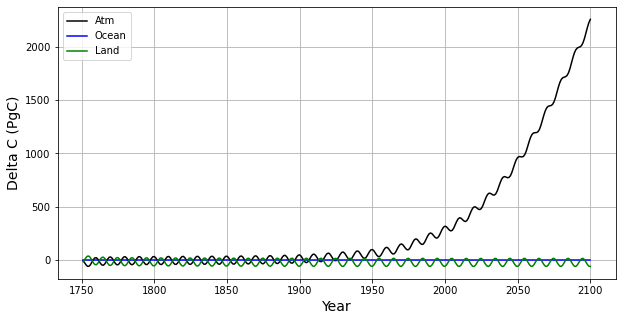

done saving file


In [15]:
pt = range(tcal.size)

fig = plt.figure(figsize=(10,5))
ax=plt.axes()

# 
ax.plot(tcal[pt], dCatm[pt], color='k', label='Atm')
ax.plot(tcal[pt], dCoc[pt], color='b', label='Ocean')
ax.plot(tcal[pt], dCla[pt], color='g',label='Land')

ax.legend()
plt.grid()

# add axis labels
plt.ylabel('Delta C (PgC)',fontsize=14)
plt.xlabel('Year',fontsize=14)

# show the plot:
plt.show()

# save the plot
fig.savefig('CO2_reservoir_total_' +PS['runName'] +'.png', bbox_inches='tight')
print('done saving file')

# close the plot (so python stops trying to hold on to it in memory; you can
# still look at it at this point, but you're done editing)
plt.close()


## D.2 Plot Land components

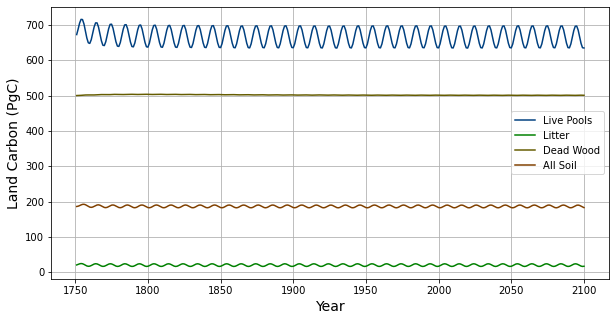

done saving file


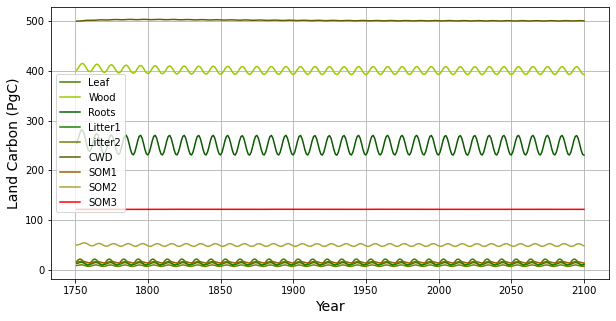

done saving file


In [16]:
# if we ran the land make land plots
if PS['DoTer'] == 1:
    
    # Plot 1
    fig = plt.figure(figsize=(10,5))
    ax=plt.axes()

    ax.plot(tcal[pt], res['veg']*12e-15, color=np.divide([0,64,128],255), label='Live Pools')
    ax.plot(tcal[pt], res['lit']*12e-15, color='g', label='Litter')
    ax.plot(tcal[pt], res['cwd']*12e-15, color=np.divide([101,92,0],255), label='Dead Wood')
    ax.plot(tcal[pt], res['som']*12e-15, color=np.divide([128,64,0],255), label='All Soil')

    ax.legend()
    plt.grid()

    # add axis labels
    plt.ylabel('Land Carbon (PgC)',fontsize=14)
    plt.xlabel('Year',fontsize=14)

    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('CO2_reservoir_land_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()



    # Plot 2
    fig = plt.figure(figsize=(10,5))
    ax=plt.axes()

    # 
    ax.plot(tcal[pt], res['cla'][PL['iLeaf'],:]*12e-15, color=np.divide([64, 128, 0],255), label='Leaf')
    ax.plot(tcal[pt], res['cla'][PL['iWood'],:]*12e-15, color=np.divide([153, 204, 0],255), label='Wood')
    ax.plot(tcal[pt], res['cla'][PL['iRoot'],:]*12e-15, color=np.divide([11, 90, 2],255), label='Roots')

    ax.plot(tcal[pt], res['cla'][PL['iLit1'],:]*12e-15, color=np.divide([25, 131, 0],255), label='Litter1')
    ax.plot(tcal[pt], res['cla'][PL['iLit2'],:]*12e-15, color=np.divide([112, 129, 0],255), label='Litter2')
    ax.plot(tcal[pt], res['cla'][PL['iCWDC'],:]*12e-15, color=np.divide([101, 92, 0],255), label='CWD')
    ax.plot(tcal[pt], res['cla'][PL['iSOM1'],:]*12e-15, color=np.divide([156, 98, 0],255), label='SOM1')
    ax.plot(tcal[pt], res['cla'][PL['iSOM2'],:]*12e-15, color=np.divide([170, 167, 55],255), label='SOM2')
    ax.plot(tcal[pt], res['cla'][PL['iSOM3'],:]*12e-15, color=np.divide([255, 0, 0],255), label='SOM3')


    ax.legend()
    plt.grid()

    # add axis labels
    plt.ylabel('Land Carbon (PgC)',fontsize=14)
    plt.xlabel('Year',fontsize=14)

    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('CO2_reservoir_land_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


### D.3 Plot Ocean Components

In [17]:
if PS['DoOcn'] == 1:
    
    # plot 1: -- plot Change in Ocean DIC for Different Ocean Boxes
    fig = plt.figure(figsize=(10,5))
    ax=plt.axes()

    ax.plot(tcal[pt], res['coc'][PO['iLL'],:]*1e3, color='r', label='Low Lat')
    ax.plot(tcal[pt], res['coc'][PO['iNA'],:]*1e3, color='b', label='N.Atl')
    ax.plot(tcal[pt], res['coc'][PO['iAA'],:]*1e3, color='m', label='So Ocn')
    ax.plot(tcal[pt], res['coc'][PO['iAABW'],:]*1e3, color='k', label='Deep')
    
    ax.legend()
    plt.grid()

    # add axis labels
    plt.ylabel('Ocean DIC [mmol/m3]',fontsize=14)
    plt.xlabel('Year',fontsize=14)

    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('CO2_conc_ocean_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()


    # plot 2: -- plot change in temperature for different ocean boxes
    fig = plt.figure(figsize=(10,5))
    ax=plt.axes()

    ax.plot(tcal[pt], res['tmp'][PO['iLL'],:], color='r', label='Low Lat')
    ax.plot(tcal[pt], res['tmp'][PO['iNA'],:], color='b', label='N.Atl')
    ax.plot(tcal[pt], res['tmp'][PO['iAA'],:], color='m', label='So Ocn')
    ax.plot(tcal[pt], res['tmp'][PO['iAABW'],:], color='k', label='Deep')
    
    ax.legend()
    plt.grid()

    # add axis labels
    plt.ylabel('Delta Temperature (C)',fontsize=14)
    plt.xlabel('Year',fontsize=14)

    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('Temperature_ocean_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

    # plot 3: -- plot change in nutrient concentration for Ocean boxes
    fig = plt.figure(figsize=(10,5))
    ax=plt.axes()

    ax.plot(tcal[pt], res['nut'][PO['iLL'],:], color='r', label='Low Lat')
    ax.plot(tcal[pt], res['nut'][PO['iNA'],:], color='b', label='N.Atl')
    ax.plot(tcal[pt], res['nut'][PO['iAA'],:], color='m', label='So Ocn')
    ax.plot(tcal[pt], res['nut'][PO['iAABW'],:], color='k', label='Deep')
    
    ax.legend()
    plt.grid()

    # add axis labels
    plt.ylabel('Delta Nutrients',fontsize=14)
    plt.xlabel('Year',fontsize=14)

    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('Nut_conc_ocean_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

    # close the plot (so python stops trying to hold on to it in memory; you can
    # still look at it at this point, but you're done editing)
    plt.close()

# Section E: Special case comparing coupled and uncoupled
Run the model again uncoupled, and plot comparison output

In [18]:
if PS['DoCplVUncpl']==1:
    
    PSUncpl=PS.copy() # make a copy of the PS dictionary containing run info
    PSUncpl['DoRadCO2'] = 0 # Turn off radiative coupling to get a comparison solution
    
    ### Set an initial state for the whole model
    # prescribe or compute initial size of each reservoir/pool
    if PSUncpl['DoOcn'] == 1:
        Nut_o = PO['Peq'] * 1e-3 # initial ocean nutrient concentration in each box (mol/m3)
        Coc_o = np.array([2388, 2351, 2322, 2325, 2120, 2177, 2329]) * 1e-3 # initial ocean DIC (mol/m3)
        Tmp_o = 0*Nut_o # initial temperature anomaly (deg C)

    lt_side = -1* np.matmul(PL['acoef'], PL['krate'])
    rt_side = (PL['bcoef'] * PL['NPP_o']).reshape(9, 1)
    Cla_o = np.linalg.solve(lt_side, rt_side) # initial land carbon (steady state)
    Cat_o = PE['patm0'] # initial atmos. pCO2 (uatm, or ppm)

    # package initial values into array
    # this makes it easier to identify domains (rows) and pools (columns)
    y0mat = PE['m0'] # start with dummy matrix

    y0mat_shape = y0mat.shape
    y0mat_flat = y0mat.flatten()

    y0mat_flat[PE['Icla']] = Cla_o.flatten()
    y0mat_flat[PE['Iatm']] = Cat_o

    if PSUncpl['DoOcn'] == 1:
        y0mat_flat[PE['Itmp']] = Tmp_o.flatten() # put temperature values into matrix
        y0mat_flat[PE['Inut']] = Nut_o.flatten() # ditto ocean nutrient, etc.
        y0mat_flat[PE['Icoc']] = Coc_o.flatten()

    y0mat = y0mat_flat.reshape(y0mat_shape)
    
    #### integrate forward
    # convert matrix of initial values to a vector (required for ode solver)
    y0=y0mat.flatten()[PE['Ires']].reshape(1, len(PE['Ires']))

    # set time for integration
    trun = np.arange(0, PSUncpl['ytot']*PE['spery'] + PE['spery'], PE['spery'])

    #### iterate the model forward and solve
    # use functools to give input args to carbon_climate_derivs before the solver sees it 
    new_deriv = partial(carbon_climate_derivs, PE=PE, PS=PSUncpl, PL=PL, PO=PO)
    solUncpl = integrate.solve_ivp(new_deriv, [trun[0], trun[-1]], y0=y0.flatten(), method='BDF', t_eval=trun)
    
    #### proces uncoupled results
    # sol.y is results, sol.t is time points that the solver evaluated
    # NOTE: y.shape is (num_pools, num_time_points)

    # new ordered dict for results 
    resUncpl = OrderedDict()

    # swap x and y axes of solution array 
    y_swap = np.swapaxes(solUncpl.y, 0, 1)

    resUncpl['tmp'] = y_swap[kt,:][:, PE['Jtmp']].transpose()
    resUncpl['nut'] = y_swap[kt,:][:, PE['Jnut']].transpose()
    resUncpl['coc'] = y_swap[kt,:][:, PE['Jcoc']].transpose()
    resUncpl['cla'] = y_swap[kt,:][:, PE['Jcla']].transpose() * PL['Ala']
    resUncpl['atm'] = y_swap[kt,:][:, PE['Jatm']].transpose()

    # combined land pools
    resUncpl['veg'] = np.sum(resUncpl['cla'][np.array([PL['iLeaf'], PL['iRoot'], PL['iWood']]), :],0) # vegetation: leaf + root + wood
    resUncpl['lit'] = np.sum(resUncpl['cla'][np.array([PL['iLit1'], PL['iLit2']]),:],0) # litter: metabolic + structural
    resUncpl['cwd'] = np.sum(resUncpl['cla'][np.array([PL['iCWDC']]),:],0) # coarse woody debris
    resUncpl['som'] = np.sum(resUncpl['cla'][np.array([PL['iSOM1'], PL['iSOM2'], PL['iSOM3']]),:],0) # soil organic matter (active+slow+passive)

    # Psi=Psi./repmat(V',[1 PE.nb]) % divide by volume to get timescale
    # Psi = Psi / np.tile(V.reshape(7, 1), (1, 7))

    # net change ocn
    ##junk = V.coc-repmat(V.coc(:,1),[1 length(tcal)]); ## MATLAB
    junk = resUncpl['coc'] - np.tile(resUncpl['coc'][:,0],(np.size(tcal),1)).transpose() # subtract the first time point to get a difference time series

    ##dCoc = sum(junk.*repmat(PO.V',[1 length(tcal)]))*12e-15; ## MATLAB
    dCoc = np.sum(junk*np.tile(PO['V'],(np.size(tcal),1)).transpose(),0)*12e-15 # nultiply by the volume of the ocean in each box, then sum

    # net change land
    junk = np.sum(resUncpl['cla'], 0)
    #if PS['DoTer'] == 1:
    #    dCla = (junk - junk[1]) * 12e-15
    #    res['dCla'] = dCla
    dCla = (junk - junk[1]) * 12e-15


    # net change atm
    dCatm = (resUncpl['atm'] - PE['patm0']) * PE['ma'] * 12e-15

    # store in dictionary
    resUncpl['dCla'] = dCla
    resUncpl['tcal'] = tcal
    resUncpl['dCoc'] = dCoc
    resUncpl['dCatm'] = dCatm
    
  

### Section E.1 Plot Figure 1 from Friedlingstein et al. 2006

In [19]:
if PS['DoCplVUncpl']==1:
    
    ### Plot Figure 1 from Friedlingstein et al. 2006
    
    # Define whole figure
    #fig = plt.figure(figsize=(15,10))
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

    ###
    
    #Panel a - Atmospheric CO2
    ax[0,0].plot(tcal[pt], res['atm']*1e6, color='r',label='Coupled')
    ax[0,0].plot(tcal[pt], resUncpl['atm']*1e6, color='k',label='Uncoupled')
    
    # plot charachteristics
    ax[0,0].grid() # add grid lines
    # add axis labels
    ax[0,0].set_ylabel('Atm CO_2 (ppm)',fontsize=14)
    ax[0,0].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[0,0].set_ylim(280,1e3)
    ax[0,0].set_xlim(1850,2100)
    ax[0,0].legend()
    
    ####
    
    #Panel b - Atmospheric CO2 difference
    ax[0,1].plot(tcal[pt], (res['dCatm']-resUncpl['dCatm'])/2,color='k')

    
    # plot charachteristics
    ax[0,1].grid() # add grid lines
    # add axis labels
    ax[0,1].set_ylabel('Atm CO_2 difference (ppm)',fontsize=14)
    ax[0,1].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[0,1].set_ylim(0,250)
    ax[0,1].set_xlim(1850,2100) 
    

    ####
    
    #Panel c - Land Carbon
    ax[1,0].plot(tcal[pt[1:]], np.diff(res['dCla']),color='r',label='Coupled')
    ax[1,0].plot(tcal[pt[1:]], np.diff(resUncpl['dCla']),color='g',label='Uncoupled')
    
    # plot charachteristics
    ax[1,0].grid() # add grid lines
    # add axis labels
    ax[1,0].set_ylabel('Land uptake (GtC)',fontsize=14)
    ax[1,0].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[1,0].set_ylim(-7,12)
    ax[1,0].set_xlim(1850,2100) 
    ax[1,0].legend()

    ####
    
    #Panel d - Land C difference
    ax[1,1].plot(tcal[pt[1:]], np.diff(res['dCla'])-np.diff(resUncpl['dCla']),color='g')
    
    # plot charachteristics
    ax[1,1].grid() # add grid lines
    # add axis labels
    ax[1,1].set_ylabel('Land uptake difference (GtC/yr)',fontsize=14)
    ax[1,1].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[1,1].set_ylim(-12,2)
    ax[1,1].set_xlim(1850,2100) 

    ####
    
    #Panel d - Ocean Carbon  
    ax[2,0].plot(tcal[pt[1:]], np.diff(res['dCoc']),color='r',label='Coupled')
    ax[2,0].plot(tcal[pt[1:]], np.diff(resUncpl['dCoc']),color='b',label='Uncoupled')
    
    # plot charachteristics
    ax[2,0].grid() # add grid lines
    # add axis labels
    ax[2,0].set_ylabel('Ocean uptake (GtC)',fontsize=14)
    ax[2,0].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[2,0].set_ylim(-0.5,13)
    ax[2,0].set_xlim(1850,2100) 
    ax[2,0].legend()

    ####
    
    #Panel e - Ocean C difference    
    ax[2,1].plot(tcal[pt[1:]], np.diff(res['dCoc'])-np.diff(resUncpl['dCoc']),color='b')
    
    # plot charachteristics
    ax[2,1].grid() # add grid lines
    # add axis labels
    ax[2,1].set_ylabel('Ocean uptake difference (GtC/yr)',fontsize=14)
    ax[2,1].set_xlabel('Year',fontsize=14)
    # set axes limits
    ax[2,1].set_ylim(-2,1.5)
    ax[2,1].set_xlim(1850,2100) 

    ####
    plt.title('Friedlingstein et al. 2006 Fig. 1, red = coupled, color=uncoupled')
    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('CplVUncpl_Friedlingstein06_Fig1_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')

### Section E.2 Plot Figure 2 from Friedlingstein et al. 2006

In [20]:
if PS['DoCplVUncpl']==1:
    
    ### Plot Figure 2 from Friedlingstein et al. 2006
    
    # calculate one more thing
    dTbar=np.zeros(np.shape(tcal))
    relarea=PO['A'][PO['Isfc']]/np.sum(PO['A'][PO['Isfc']])
    dTbar=np.sum(res['tmp'][PO['Isfc'],:]*np.tile(relarea,(len(tcal),1)).transpose(),0)
    
    
    # Define whole figure
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

    ###

    #Panel a - Surface T change
    ax[0,0].plot(res['atm']*1e6, dTbar,color='k')
    
    # plot charachteristics
    ax[0,0].grid() # add grid lines
    # add axis labels
    ax[0,0].set_ylabel('Surface Temperature Change (K)',fontsize=14)
    ax[0,0].set_xlabel('Atm CO_2 (ppm)',fontsize=14)
    # set axes limits
    ax[0,0].set_xlim(280,1e3)
    ax[0,0].set_ylim(-1,5.5)
    
    ####
    
    #Panel b - Land C uncoupled
    ax[1,0].plot(resUncpl['atm'][1:]*1e6, np.cumsum(np.diff(resUncpl['dCla'])),color='g')
    
    # plot charachteristics
    ax[1,0].grid() # add grid lines
    # add axis labels
    ax[1,0].set_ylabel('Change in Land Uptake (GtC)',fontsize=14)
    ax[1,0].set_xlabel('Atm CO_2 (ppm)',fontsize=14)
    # set axes limits
    ax[1,0].set_xlim(280,1e3)
    ax[1,0].set_ylim(0,1200) 

    ####
    
    #Panel c - Ocean C uncoupled
    ax[1,1].plot(resUncpl['atm'][1:]*1e6, np.cumsum(np.diff(resUncpl['dCoc'])),color='b')
    
    # plot charachteristics
    ax[1,1].grid() # add grid lines
    # add axis labels
    ax[1,1].set_ylabel('Change in Ocean Uptake (GtC)',fontsize=14)
    ax[1,1].set_xlabel('Atm CO_2 (ppm)',fontsize=14)
    # set axes limits
    ax[1,1].set_xlim(280,1e3)
    ax[1,1].set_ylim(0,900) 

    
    ####
    
    #Panel e - Land C Difference
    ax[2,0].plot(dTbar, res['dCla']-resUncpl['dCla'],color='g')
    
    # plot charachteristics
    ax[2,0].grid() # add grid lines
    # add axis labels
    ax[2,0].set_ylabel('Change in Land Uptake (GtC)',fontsize=14)
    ax[2,0].set_xlabel('Surface Temperature Change (K)',fontsize=14)
    # set axes limits
    ax[2,0].set_xlim(1,5)
    ax[2,0].set_ylim(-850,100) 

    
    ####
    
    #Panel f - Ocean C Difference
    ax[2,1].plot(dTbar, res['dCoc']-resUncpl['dCoc'],color='b')
    
    # plot charachteristics
    ax[2,1].grid() # add grid lines
    # add axis labels
    ax[2,1].set_ylabel('Change in Ocean Uptake (GtC)',fontsize=14)
    ax[2,1].set_xlabel('Surface Temperature Change (K)',fontsize=14)
    # set axes limits
    ax[2,1].set_xlim(1,5)
    ax[2,1].set_ylim(-240,40) 
    
    
    ####
    
    # show the plot:
    plt.show()

    # save the plot
    fig.savefig('CplVUncpl_Friedlingstein06_Fig2_' +PS['runName'] +'.png', bbox_inches='tight')
    print('done saving file')